In [230]:
import lightgbm
from sklearn.model_selection import GroupKFold, KFold, GridSearchCV, cross_validate, train_test_split, cross_val_score, cross_val_predict
import pandas as pd
import shap
from sklearn import metrics
from sklearn.feature_selection import SelectKBest
import numpy as np
from sklearn.feature_selection import mutual_info_regression

In [231]:
df = pd.read_csv("../data/interim/sample.csv")
df1 = pd.read_csv("../data/interim/model_torchxray.csv")

In [232]:
df = pd.merge(df, df1, on="fname")

In [233]:
df = df.loc[df["gt"] == "expert"]

In [234]:
df["false_positive"] = ~df.true & ~df.positive_gt
df["false_negative"] = ~df.true & df.positive_gt

In [235]:
df[['iou', 'iomax', 'dice_at_tolerance']] = df[['iou', 'iomax', 'dice_at_tolerance']].fillna(1.0)
df.loc[~df.positive_gt & df.true, "iomin"] = df.loc[~df.positive_gt & df.true, "iomin"].fillna(1.0)
df["iomin"].fillna(0.0, inplace=True)

In [255]:
df[['f1_0.0']].max()

f1_0.0    1.0
dtype: float64

In [236]:
df.head(5)

,id,fname,sample_name,y,gt,iou,iomin,iomax,dice,dice_el,...,Mass,Hernia,Lung Lesion,Fracture,Lung Opacity,Enlarged Cardiomediastinum,No Finding,No Finding Sum,false_positive,false_negative
0,00000181_061_1,00000181_061,1,4.0,expert,0.350949,0.985127,0.352818,0.519561,0.475900,...,0.547738,0.012142,0.139100,0.523429,0.593831,0.530269,0.398298,-8.776658,False,False
1,00000181_061_2,00000181_061,2,4.0,expert,0.237160,1.000000,0.237160,0.383396,0.412101,...,0.547738,0.012142,0.139100,0.523429,0.593831,0.530269,0.398298,-8.776658,False,False
2,00000181_061_3,00000181_061,3,3.0,expert,0.381895,0.587954,0.521455,0.552716,0.494049,...,0.547738,0.012142,0.139100,0.523429,0.593831,0.530269,0.398298,-8.776658,False,False
3,00013977_005_1,00013977_005,1,NaN,expert,0.000000,0.000000,0.000000,0.000021,0.000027,...,0.584497,0.014976,0.263935,0.111970,0.065350,0.386314,0.415503,-4.553343,False,True
4,00013977_005_2,00013977_005,2,NaN,expert,0.791545,0.930406,0.841359,0.883646,0.896229,...,0.584497,0.014976,0.263935,0.111970,0.065350,0.386314,0.415503,-4.553343,False,False


In [237]:
predictors = [col for col in df.columns if col not in ["id", "fname", "sample_name", "y", "Unnamed: 0", "gt"]]
# predictors_metrics = [pred for pred in predictors if pred in ["iou", "iomin", "iomax", "gt_sum", "gt_sum_pos", "true", "positive_gt", "false_positive", "false_negative"]]

In [238]:
fnames = list(df.fname.unique())
# fnames_train, fnames_test = train_test_split(fnames, train_size=0.8, random_state=24, shuffle=True)

In [239]:
# predictors = predictors_metrics

In [240]:
df_train = df.loc[~pd.isnull(df.y)].copy()
df_test = df = df.loc[pd.isnull(df.y)].copy()

In [241]:
df_train.corr()["y"].sort_values().tail(30)

area_model           0.116341
area_expert          0.126206
Mass                 0.145054
Fibrosis             0.147194
pixel_accuracy       0.157082
ssim                 0.160405
Nodule               0.183918
precision_0.5        0.212571
recall_0.5           0.368430
precision_0.25       0.383270
true                 0.421967
pixel_precision      0.470474
precision_0.0        0.476173
pixel_recall         0.497225
f1_0.5               0.509994
recall_0.25          0.524027
dice_at_tolerance    0.530971
recall_0.0           0.566940
iomin                0.624097
pixel_f1             0.636096
f1_0.25              0.689023
iou                  0.735455
iomax                0.737239
leg_f1_0.0           0.748622
dice_el              0.753659
f1_0.0               0.757279
leg_f1_0.25          0.760230
dice_rect            0.763791
dice                 0.766292
y                    1.000000
Name: y, dtype: float64

In [242]:
df_train.corr()["y"].sort_values().tail(15)

recall_0.25          0.524027
dice_at_tolerance    0.530971
recall_0.0           0.566940
iomin                0.624097
pixel_f1             0.636096
f1_0.25              0.689023
iou                  0.735455
iomax                0.737239
leg_f1_0.0           0.748622
dice_el              0.753659
f1_0.0               0.757279
leg_f1_0.25          0.760230
dice_rect            0.763791
dice                 0.766292
y                    1.000000
Name: y, dtype: float64

In [243]:
X_train = df_train[predictors].fillna(0.0)
X_train = X_train.replace([np.inf], 100000.0)
df_test[predictors] = df_test[predictors].fillna(0.0)
df_test = df_test.replace([np.inf], 100000.0)
y_train = df_train["y"]

In [244]:
corr_matrix = X_train.corr()
threshold = 0.9
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if (corr_matrix.iloc[i, j] >= threshold):
            print(corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])

iomax iou 0.9866099983464108
dice iou 0.9799397539257453
dice iomax 0.9802335536133366
dice_el iou 0.9715657199744687
dice_el iomax 0.9660928588159197
dice_el dice 0.9876787403482762
dice_rect iou 0.9670128792357993
dice_rect iomax 0.9668758610891093
dice_rect dice 0.9893021364259863
dice_rect dice_el 0.9953643944925447
leg_f1_0.0 f1_0.0 0.9684560956804819
leg_f1_0.25 f1_0.0 0.9006579598281884
leg_f1_0.25 leg_f1_0.0 0.9254520826745741
min_centroid_dist mean_centroid_dist 0.9125527408217419
pixel_accuracy ssim 0.9999569238078705
false_positive dist_inv 0.9999998657546093
false_negative dist 0.999999924406309


In [245]:
# To be used within GridSearch (5 in your case)
inner_cv = GroupKFold(n_splits=5)

# To be used in outer CV (you asked for 10)
outer_cv = GroupKFold(n_splits=10)

In [246]:
from sklearn.base import BaseEstimator 
from sklearn.base import RegressorMixin

# could not use Pipeline, sklearn doesn't allow cloning Pipelines
class CustomRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, **estimator_params):
        super().__init__()
        self.selector = SelectKBest(score_func=mutual_info_regression, k="all")
        self.base_model = lightgbm.LGBMRegressor(random_state=24, objective="regression_l1")
        self.set_params(**estimator_params)

    def fit(self, X, y=None):
        X_tr = self.selector.fit_transform(X, y)
        self.base_model.fit(X_tr, y)
        return self

    def predict(self, X):
        X_tr = self.selector.transform(X)
        y = self.base_model.predict(X_tr)
        y[X.false_positive == 1] = 1
        y[X.false_negative == 1] = 1
        y[(X.area_model + X.area_expert) == 0] = 5
        y = np.round(y, 0)
        return y
    
    def get_params(self, **params):
        pars = self.base_model.get_params()
        pars["k"] = self.selector.k
        return pars
    
    def set_params(self, **params):
        if "k" in params:
            k = params.pop("k")
            self.selector = self.selector.set_params(k=k)
        self.base_model = self.base_model.set_params(**params)
        return self

In [247]:
model = CustomRegressor()
param_grid = {
    "n_estimators": [50, 100, 200, 300],
    "colsample_bytree": [0.25, 0.5, 0.75, 1.0],
    "min_child_samples": [1, 3, 5, 10],
    "num_leaves": [5, 7, 15, 31],
    #"zero_as_missing": [False, True],
    "k": [15, 30, len(predictors)],
    "lambda_l1": [0.0, 0.1, 1.0],
    "lambda_l2": [0.0, 0.1, 1.0]
}
param_grid = {
    "n_estimators": [50, 100, 200, 300],
    "colsample_bytree": [0.25, 0.5, 1.0],
    "min_child_samples": [1, 5],
    "num_leaves": [5, 7, 15, 31],
    #"zero_as_missing": [False, True],
    "k": [15, 30, len(predictors)],
    "lambda_l1": [0.1, 1.0],
    "lambda_l2": [0.1, 1.0]
}

In [23]:
pred_y = []
true_y = []
for train_index, test_index in outer_cv.split(X_train, y_train, groups=df_train.fname):
    X_tr, X_tt = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
    y_tr, y_tt = y_train.iloc[train_index], y_train.iloc[test_index]
    groups_tt = df_train.fname.iloc[train_index]
    source_ind = (df_train["gt"].iloc[test_index] == "expert").values

    clf = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, verbose=True, n_jobs=-1, scoring="neg_mean_absolute_error")
    clf.fit(X_tr,y_tr, groups=groups_tt)

    pred = clf.predict(X_tt)
    pred_y.extend(pred[source_ind])
    true_y.extend(y_tt[source_ind])
    nested_score = metrics.mean_absolute_error(true_y, pred_y)
    nested_accuracy = metrics.accuracy_score(true_y, pred_y)
    print(nested_score, nested_accuracy)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed:  2.5min finished


0.2777777777777778 0.7222222222222222
Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  1.7min


KeyboardInterrupt: 

In [ ]:
nested_score = metrics.mean_absolute_error(true_y, pred_y)
nested_accuracy = metrics.accuracy_score(true_y, pred_y)

In [248]:
inner_cv = GroupKFold(n_splits=5)
clf = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, n_jobs=-1, refit=True, verbose=True, scoring="neg_mean_absolute_error")
clf.fit(X_train, y_train, groups=df_train.fname)
non_nested_score = -clf.best_score_

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed:  2.8min finished


In [249]:
non_nested_score

0.4222222222222222

In [252]:
clf.best_params_

{'colsample_bytree': 0.25,
 'k': 15,
 'lambda_l1': 0.1,
 'lambda_l2': 1.0,
 'min_child_samples': 5,
 'n_estimators': 50,
 'num_leaves': 7}

In [ ]:
print("All predictors", nested_score, nested_accuracy, non_nested_score)

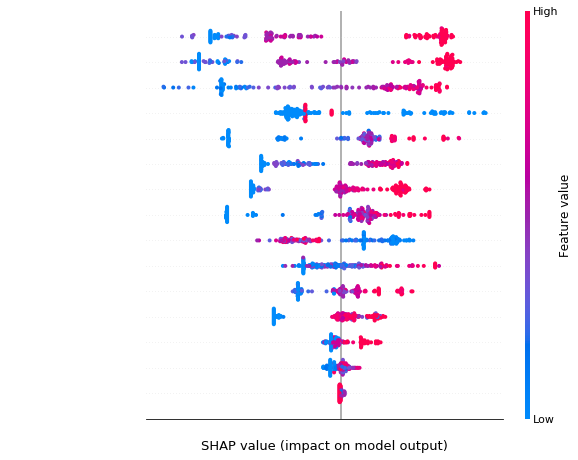

In [251]:
X_tr = clf.best_estimator_.selector.transform(X_train)
explainer = shap.TreeExplainer(clf.best_estimator_.base_model)
shap_values = explainer.shap_values(X_tr)
topk = clf.best_estimator_.selector.get_support()
shap.summary_plot(shap_values, X_tr, axis_color="white", feature_names=X_train.columns[topk])

In [ ]:
model = model.set_params(**clf.best_params_)
df_train['prediction'] = cross_val_predict(model, X_train, y_train, cv=inner_cv, groups=df_train.fname)
df_test['prediction'] = clf.predict(df_test[predictors].fillna(0.0))

In [ ]:
def rand_jitter(arr):
    stdev = .02 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

In [ ]:
df_train['prediction_jitter'] = rand_jitter(df_train.prediction)

In [ ]:
df_train.plot.scatter("y", "prediction_jitter", figsize=(8, 8))

In [ ]:
df_train.corr()['y'].sort_values()

In [ ]:
df_test.prediction.hist()

In [ ]:
df_train.y.hist()